In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from transformers import T5Tokenizer, T5ForConditionalGeneration

import torch
import torch.nn as nn

In [61]:
tot = pd.read_csv("../input/quotes-500k/quotes.csv")

In [62]:
tot.head()

,quote,author,category
0,"I'm selfish, impatient and a little insecure. ...",Marilyn Monroe,"attributed-no-source, best, life, love, mistak..."
1,You've gotta dance like there's nobody watchin...,William W. Purkey,"dance, heaven, hurt, inspirational, life, love..."
2,You know you're in love when you can't fall as...,Dr. Seuss,"attributed-no-source, dreams, love, reality, s..."
3,A friend is someone who knows all about you an...,Elbert Hubbard,"friend, friendship, knowledge, love"
4,Darkness cannot drive out darkness: only light...,"Martin Luther King Jr., A Testament of Hope: T...","darkness, drive-out, hate, inspirational, ligh..."


In [63]:
df = tot.sample(1000).reset_index(drop = True)

In [5]:
sents = df["quote"]

In [6]:
class CustDat(torch.utils.data.Dataset):
    def __init__(self , sents , tokenizer):
        self.sents = sents
        self.tokenizer = tokenizer
    def __len__(self):
        return len(self.sents)
    def __getitem__(self , idx):
        sent = self.sents[idx]
        words = sent.split()
        prompt = " ".join(words[:3])
        txt = " ".join(words)
        source = self.tokenizer.batch_encode_plus(
            [prompt],
            max_length=512,
            pad_to_max_length=True,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )
        target = self.tokenizer.batch_encode_plus(
            [txt],
            max_length=80,
            pad_to_max_length=True,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )
        source_ids = source["input_ids"].squeeze()
        source_mask = source["attention_mask"].squeeze()
        target_ids = target["input_ids"].squeeze()
        
        return{
            "source_ids" : source_ids.to(dtype = torch.long) , 
            "source_mask" : source_mask.to(dtype = torch.long) , 
            "target_ids" : target_ids.to(dtype = torch.long)
        }

In [7]:
tokenizer = T5Tokenizer.from_pretrained("t5-base")

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

/opt/conda/lib/python3.7/site-packages/transformers/models/t5/tokenization_t5.py:174: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


In [8]:
train_dl = torch.utils.data.DataLoader(CustDat(sents , tokenizer) , 
                                      batch_size = 16 , 
                                      shuffle = False)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [10]:
model = T5ForConditionalGeneration.from_pretrained("t5-base")

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

In [11]:
model = model.to(device)

In [12]:
optimizer = torch.optim.SGD(model.parameters() , lr = 0.001)

In [13]:
num_epochs = 10
losses = []
for epoch in range(num_epochs):
    epoch_loss = 0
    for data in train_dl:
        source_ids = data["source_ids"].to(device)
        attention_mask = data["source_mask"].to(device)
        targs = data["target_ids"].to(device)
        targs[targs == tokenizer.pad_token_id] = -100
        loss = model(input_ids = source_ids , attention_mask = attention_mask , labels = targs).loss
        epoch_loss += loss.cpu().detach().numpy()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    losses.append(epoch_loss)

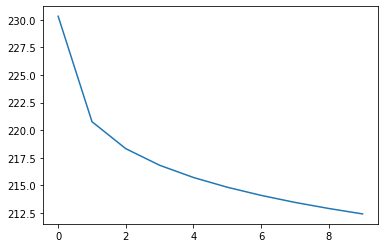

In [14]:
plt.plot(losses)

In [68]:
source = tokenizer.batch_encode_plus(
            ["Beauty lies in"],
            max_length=512,
            pad_to_max_length=True,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )["input_ids"]

In [69]:
res = model.generate(source.to(device) , max_length = 50)

In [70]:
print(tokenizer.decode(res[0], skip_special_tokens=True))

Beauty lies in the midst of the chaos of the world.


In [64]:
tot.sample()

,quote,author,category
482728,"I find it amusing on one level, poignant on an...",Grace Slick,"People, Try, Find"
